# CS6140 Project - Detection Of Sarcasm In Text

## 1. Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim
import gensim.downloader as api
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
import math

In [3]:
#Run if running notebook with vectors locally for first time. Files added to gitignore
glove = api.load('glove-wiki-gigaword-300')
glove.save('glovevectors.bin')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [4]:
glove = KeyedVectors.load('glovevectors.bin')

In [5]:
# Run these if not up to date
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [16]:
#glove_vocab = glove.key_to_index
glove.vocab['the'].index

glove_vocab = {}
for entry in glove.vocab:
  glove_vocab[entry] = glove.vocab[entry].index

In [18]:
glove_vocab['the']

0

In [19]:
torch.cuda.is_available()

True

In [20]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
#device = torch.device('cpu')

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [22]:
data = pd.read_csv("train-balanced-sarcasm.csv")

In [23]:
data = data[['label', 'comment', 'subreddit', 'score', 'parent_comment']]

In [24]:
data.head(10)

,label,comment,subreddit,score,parent_comment
0,0,NC and NH.,politics,2,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,-4,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",nfl,3,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,-8,deadass don't kill my buzz
4,0,I could use one of those tools.,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",AskReddit,0,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,AskReddit,1,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,FFBraveExvius,2,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",pcmasterrace,1,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,Lollapalooza,2,Probably count Kanye out Since the rest of his...


In [25]:
data.isna().sum()

label              0
comment           53
subreddit          0
score              0
parent_comment     0
dtype: int64

In [26]:
data = data.dropna(axis=0)

In [27]:
data.isna().sum()

label             0
comment           0
subreddit         0
score             0
parent_comment    0
dtype: int64

In [28]:
data['comment_tokens'] = data['comment']
data['comment_tokens'] = data['comment_tokens'].str.lower()
data['comment_tokens'] = data['comment_tokens'].str.replace('can\'t','can not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('\'d',' would',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('wouldn\'t','would not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('couldn\'t','could not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('[^\w\s]','', regex = True)

In [29]:
data['parent_comment_tokens'] = data['parent_comment']
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.lower()
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('can\'t','can not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('\'d',' would',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('wouldn\'t','would not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('couldn\'t','could not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('[^\w\s]','', regex = True)

In [30]:
lemma = WordNetLemmatizer()
def apply_lemmatizer(sentence):
    return [lemma.lemmatize(token) for token in wordpunct_tokenize(sentence)]

In [31]:
data["comment_tokens"] = data.comment_tokens.apply(apply_lemmatizer)
data["parent_comment_tokens"] = data.parent_comment_tokens.apply(apply_lemmatizer)

In [32]:
data[["comment", "comment_tokens"]].head(10)

,comment,comment_tokens
0,NC and NH.,"[nc, and, nh]"
1,You do know west teams play against west teams...,"[you, do, know, west, team, play, against, wes..."
2,"They were underdogs earlier today, but since G...","[they, were, underdog, earlier, today, but, si..."
3,"This meme isn't funny none of the ""new york ni...","[this, meme, isnt, funny, none, of, the, new, ..."
4,I could use one of those tools.,"[i, could, use, one, of, those, tool]"
5,"I don't pay attention to her, but as long as s...","[i, dont, pay, attention, to, her, but, a, lon..."
6,Trick or treating in general is just weird...,"[trick, or, treating, in, general, is, just, w..."
7,Blade Mastery+Masamune or GTFO!,"[blade, masterymasamune, or, gtfo]"
8,"You don't have to, you have a good build, buy ...","[you, dont, have, to, you, have, a, good, buil..."
9,I would love to see him at lolla.,"[i, would, love, to, see, him, at, lolla]"


In [33]:
data['comment_tokens'].shape

(1010773,)

In [34]:
data[["parent_comment", "parent_comment_tokens"]].head(10)

,parent_comment,parent_comment_tokens
0,"Yeah, I get that argument. At this point, I'd ...","[yeah, i, get, that, argument, at, this, point..."
1,The blazers and Mavericks (The wests 5 and 6 s...,"[the, blazer, and, maverick, the, west, 5, and..."
2,They're favored to win.,"[theyre, favored, to, win]"
3,deadass don't kill my buzz,"[deadass, dont, kill, my, buzz]"
4,Yep can confirm I saw the tool they use for th...,"[yep, can, confirm, i, saw, the, tool, they, u..."
5,do you find ariana grande sexy ?,"[do, you, find, ariana, grande, sexy]"
6,What's your weird or unsettling Trick or Treat...,"[whats, your, weird, or, unsettling, trick, or..."
7,Probably Sephiroth. I refuse to taint his grea...,"[probably, sephiroth, i, refuse, to, taint, hi..."
8,What to upgrade? I have $500 to spend (mainly ...,"[what, to, upgrade, i, have, 500, to, spend, m..."
9,Probably count Kanye out Since the rest of his...,"[probably, count, kanye, out, since, the, rest..."


In [35]:
data['parent_comment_tokens'].shape

(1010773,)

In [36]:
X = data[['comment_tokens', 'parent_comment_tokens']]

In [37]:
X.head(10)

,comment_tokens,parent_comment_tokens
0,"[nc, and, nh]","[yeah, i, get, that, argument, at, this, point..."
1,"[you, do, know, west, team, play, against, wes...","[the, blazer, and, maverick, the, west, 5, and..."
2,"[they, were, underdog, earlier, today, but, si...","[theyre, favored, to, win]"
3,"[this, meme, isnt, funny, none, of, the, new, ...","[deadass, dont, kill, my, buzz]"
4,"[i, could, use, one, of, those, tool]","[yep, can, confirm, i, saw, the, tool, they, u..."
5,"[i, dont, pay, attention, to, her, but, a, lon...","[do, you, find, ariana, grande, sexy]"
6,"[trick, or, treating, in, general, is, just, w...","[whats, your, weird, or, unsettling, trick, or..."
7,"[blade, masterymasamune, or, gtfo]","[probably, sephiroth, i, refuse, to, taint, hi..."
8,"[you, dont, have, to, you, have, a, good, buil...","[what, to, upgrade, i, have, 500, to, spend, m..."
9,"[i, would, love, to, see, him, at, lolla]","[probably, count, kanye, out, since, the, rest..."


In [38]:
Y = data[['label']]

In [39]:
Y.tail(10)

,label
1010816,1
1010817,1
1010818,1
1010819,1
1010820,1
1010821,1
1010822,1
1010823,1
1010824,1
1010825,1


In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size= 0.6)

In [41]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size = 0.5) 

In [42]:
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [43]:
y_train = y_train.reset_index(drop = True)
y_valid = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [44]:
X_train_copy = X_train.copy()
X_val_copy = X_val.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
y_test_copy = y_test.copy()

In [45]:
X_train.head(10)

,comment_tokens,parent_comment_tokens
0,"[i, second, that, notion]","[vote, stuff, butt, stuff]"
1,"[i, wish, i, didnt, have, all, of, those, self...","[tell, me, how, is, a, modern, selfie, any, di..."
2,"[mcgregor, ha, fought, 4, time, in, 14, month,...","[yup, he, a, lot, fresher, than, aldo, thats, ..."
3,"[and, for, non, brit, bird, is, a, slang, for,...","[this, is, like, dumping, a, bird, because, sh..."
4,"[radical, centrist, then]","[i, think, john, cleese, make, a, very, good, ..."
5,"[if, not, you, are, obviously, a, failure]","[just, pulled, that, date, out, of, my, as, im..."
6,"[more, like, a, show, whore]","[i, can, only, imagine, the, stress, that, put..."
7,"[you, just, study, it, out]","[just, do, the, research, brah]"
8,"[no, lion, make, them, a, frog, while, rhastas...","[and, rhasta, and, lion, both, have, sheep, sk..."
9,"[alcohol, isnt, really, that, great, for, you,...","[god, thats, fucking, disgusting, im, an, amer..."


In [46]:
len(X_train)

606463

In [47]:
data.shape

(1010773, 7)

In [ ]:
# Since comments are already preprocessed and tokenized,
# the vectorizer only needs to take tokens as they are.
tfidfVectorizer = TfidfVectorizer(analyzer=lambda tokens: tokens)
corpus = pd.concat([X_train['comment_tokens'], X_train['parent_comment_tokens']])
tfidfMatrix = tfidfVectorizer.fit_transform(corpus)
vocabulary = tfidfVectorizer.vocabulary_

In [ ]:
tfidfMatrix.shape

(1212926, 282504)

In [ ]:
# the tfidf matrix has 2021546 rows,
# where the 0 ~ 606462 rows represent original comments in the same order as those in dataset,
# and the 606463 ~ 1212926 rows represent parent comments in the same order as those in dataset;
# and the tfidf matrix has 395961 columns, each represents a word in the vocabulary.
tfidfMatrix

<1212926x282504 sparse matrix of type '<class 'numpy.float64'>'
	with 17806252 stored elements in Compressed Sparse Row format>

In [ ]:
# By using the following dict, we can obtain the index of a given word for querying tfidf matrix.
list(vocabulary.items())[0:10] 

[('damn', 70783),
 ('russian', 216671),
 ('nah', 169333),
 ('probably', 198549),
 ('modern', 164172),
 ('shit', 226125),
 ('like', 147673),
 ('justin', 136637),
 ('bieber', 41708),
 ('and', 26790)]

Once we have learned word vectors, to compute the sentence vector of a comment,
first fetch the corresponding row from the tfidf matrix (if it is the i-th original comment, then
it is the i-th row; if it is the i-th parent comment, then it is the (1010773 + i)-th row),
second for each word in the comment find its corresponding tfidf value from the row,
third compute the average of the word vectors weighted by corresponding tfidf values.

In [ ]:
tfidfMatrix.shape

(1212926, 283721)

In [ ]:
#tfidfMatrix[0,249920]

In [ ]:
vocabulary['thats']

249379

In [ ]:
tfidfMatrixtest = tfidfVectorizer.transform(pd.concat([X_test['comment_tokens'], X_test['parent_comment_tokens']]))
tfidfMatrixvalid = tfidfVectorizer.transform(pd.concat([X_val['comment_tokens'], X_val['parent_comment_tokens']]))

In [ ]:
tfidfMatrixtest.shape

(404310, 283721)

In [ ]:
X_test.head(10)

,comment_tokens,parent_comment_tokens
0,"[yeah, you, really, can, not, go, wrong, with,...","[i, decided, to, drop, randle, i, think, boyki..."
1,"[my, cushion, are, a, good, three, inch, so, i...","[really, most, of, mine, did, they, were, what..."
2,"[gave, me, the, giggle, wa, yaya, right]","[worse, than, not, getting, a, bday, cake]"
3,"[just, wanted, to, say, youve, been, very, luc...","[need, help, with, progress, hey, guy, so, i, ..."
4,"[this, give, me, hope, for, the, note, 8]","[nytimes, samsung, are, still, unaware, why, t..."
5,"[if, you, want, to, replace, your, queen, with...","[down, with, all, these, british, republican]"
6,"[lol, yes]","[forest, bound]"
7,"[even, the, nazi, could, not, get, away, from,...","[miniature, bible, smuggled, into, nazi, conce..."
8,"[with, probably, the, best, customer, service,...","[fuck, apple, they, are, an, evil, greedy, com..."
9,"[maybe, they, will, have, an, attribute, for, ...","[i, would, have, poped, surv, link, and, loote..."


In [ ]:
vocabulary['for']

100405

In [ ]:
tfidfMatrixtest[0, 100573]

0.0

In [ ]:
def generate_dataset(X, tfidfmat):
    comment_featurevec = []
    parent_featurevec = []
    
    for index, sample in X.iterrows():
        
        comment_vec = np.zeros(300)
        parent_comment_vec = np.zeros(300)
        comment_tokens = sample['comment_tokens']
        parent_comment_tokens = sample['parent_comment_tokens']
        counter1 = 0
        
        for token in comment_tokens:
            
            if token in glove and token in vocabulary:
                counter1 += 1
                comment_vec += tfidfmat[index, vocabulary[token]] * glove[token]
        
        counter2 = 0
        for token in parent_comment_tokens:
            
            if token in glove and token in vocabulary:
                counter2 += 1 
                parent_comment_vec += tfidfmat[index+len(X), vocabulary[token]] * glove[token]
        
        if counter1 != 0:
            comment_featurevec.append(comment_vec/counter1)
        else:
            comment_featurevec.append(comment_vec)
        
        if counter2 != 0:
            parent_featurevec.append(parent_comment_vec/counter2)
        else:
            parent_featurevec.append(parent_comment_vec)
            
        
    #print(len(comment_featurevec))
    X['comment_weighted_vec'] = comment_featurevec
    X['parent_weighted_vec'] = parent_featurevec
    new_df = pd.DataFrame()
        
    return X
    
    
    

In [ ]:
X_train = generate_dataset(X_train, tfidfMatrix)

In [ ]:
X_val = generate_dataset(X_val, tfidfMatrixvalid)

In [ ]:
X_test = generate_dataset(X_test, tfidfMatrixtest)

In [ ]:
X_train = X_train[['comment_weighted_vec', 'parent_weighted_vec']]
X_val = X_val[['comment_weighted_vec', 'parent_weighted_vec']]
X_test = X_test[['comment_weighted_vec', 'parent_weighted_vec']]

In [ ]:
def featurize(dataset):
    x = pd.DataFrame(dataset['parent_weighted_vec'].tolist(), columns = [i for i in range(300)])
    y = pd.DataFrame(dataset['comment_weighted_vec'].tolist(), columns = [i for i in range(300, 600)])
    return pd.concat([x, y], axis = 1)

In [ ]:
X_train = featurize(X_train)
X_val = featurize(X_val)
X_test = featurize(X_test)

In [ ]:
clf = LogisticRegression(max_iter = 500).fit(X_train, y_train.values.ravel())

In [ ]:
clf.score(X_test, y_test)

0.5964977368850635

In [ ]:
clf.score(X_val, y_val)

0.5935643441913383

In [ ]:
clf.predict(X_test.iloc[2].values.reshape(1,-1))

array([1])

Feed Forward Neural Net Begin....

In [ ]:
x_tr = torch.tensor(X_train.iloc[:,0:600].values, dtype= torch.float32)
x_val = torch.tensor(X_val.iloc[:,0:600].values, dtype= torch.float32)
x_test = torch.tensor(X_test.iloc[:,0:600].values,dtype= torch.float32)
y_tr = torch.tensor(list(y_train['label']), dtype= torch.long)
y_vali = torch.tensor(list(y_val['label']), dtype= torch.long)
y_tst = torch.tensor(list(y_test['label']), dtype= torch.long)

In [ ]:
x_tr.to(device)

tensor([[-0.0248,  0.0141, -0.0494,  ..., -0.0317,  0.0076,  0.0226],
        [-0.0096, -0.0013, -0.0602,  ..., -0.0546, -0.0038,  0.0154],
        [-0.0444,  0.0113, -0.0118,  ..., -0.0727, -0.0282,  0.0099],
        ...,
        [-0.0440,  0.0138, -0.0153,  ...,  0.0837, -0.0454, -0.0131],
        [ 0.0214,  0.0437,  0.0123,  ..., -0.0339, -0.0062, -0.0168],
        [-0.0095,  0.0027, -0.0059,  ..., -0.0492,  0.0064, -0.0106]],
       device='cuda:0')

In [ ]:
x_val.to(device)
x_test.to(device)
y_tr.to(device)
y_vali.to(device)
y_tst.to(device)

tensor([1, 0, 0,  ..., 0, 0, 1], device='cuda:0')

In [59]:
class XY(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.y)
  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [ ]:
trainset = XY(x_tr, y_tr)
valset = XY(x_val, y_vali)
testset = XY(x_test, y_tst)

In [ ]:
input_dim = 600
hidden_dim = 256
output_dim = 3
num_epochs = 100
batch_size = 128

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)

## 2. Models

In [ ]:
class FFNN(nn.Module):
    def __init__(self, layer_num, input_dim, hidden_dim, output_dim):
      super(FFNN, self).__init__()
      self.layers = [nn.Linear(input_dim, hidden_dim)]
      for i in range(1, layer_num):
        self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.ReLU())
      self.layers.append(nn.Linear(hidden_dim, output_dim))

      self.layers = nn.ModuleList(self.layers)
    
    def forward(self, x):
        for layer in self.layers:
          x = layer(x)
        return x

In [ ]:
model = FFNN(2, input_dim, hidden_dim, output_dim).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
val_losses = []
val_loss_min = math.inf
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    
    model.train()
    for data, target in trainloader:
      optimizer.zero_grad()
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      optimizer.zero_grad() 
      loss = loss_fn(output, target)  
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
      inpt = []
    
    model.eval()
    for data, target in valloader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = loss_fn(output, target)    
      val_loss += loss.item()
    
    train_losses.append(train_loss/len(trainloader))
    val_losses.append(val_loss/len(valloader))

    if val_loss <= val_loss_min:
      torch.save(model.state_dict(), 'model.pt')
      val_loss_min = val_loss 
    if (epoch + 1) % 20 == 0:
      print("Epoch completed: " + str(epoch+1) +
            f"\n\tTraining Loss: {train_losses[epoch]:.3f}" + 
            f"\n\tValidation Loss: {val_losses[epoch]:.3f}\n")

Epoch completed: 20
	Training Loss: 0.589
	Validation Loss: 0.571

Epoch completed: 40
	Training Loss: 0.572
	Validation Loss: 0.548

Epoch completed: 60
	Training Loss: 0.562
	Validation Loss: 0.537

Epoch completed: 80
	Training Loss: 0.556
	Validation Loss: 0.585

Epoch completed: 100
	Training Loss: 0.551
	Validation Loss: 0.589



In [ ]:
from sklearn.metrics import classification_report
preds = []
labels = torch.tensor(list(y_val['label'].values))
model = FFNN(2, input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('model.pt'))
with torch.no_grad():
    for index, row in X_val.iterrows():
        output = model(torch.Tensor(row))
        preds.append(torch.argmax(output, dim=0))
        
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65    100991
           1       0.65      0.64      0.64    101164

    accuracy                           0.65    202155
   macro avg       0.65      0.65      0.65    202155
weighted avg       0.65      0.65      0.65    202155



In [ ]:
from sklearn.metrics import classification_report
preds = []
labels = torch.tensor(list(y_test['label'].values))
model = FFNN(2, input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('model.pt'))
with torch.no_grad():
    for index, row in X_test.iterrows():
        output = model(torch.Tensor(row))
        preds.append(torch.argmax(output, dim=0))
        
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65    101295
           1       0.65      0.64      0.65    100860

    accuracy                           0.65    202155
   macro avg       0.65      0.65      0.65    202155
weighted avg       0.65      0.65      0.65    202155



## 3. Evaluation

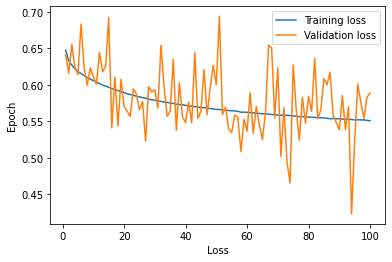

In [ ]:
plt.plot(list(range(1,len(train_losses) + 1)), train_losses, label = "Training loss")
plt.plot(list(range(1,len(val_losses) +1)), val_losses, label = "Validation loss")
plt.legend()
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.show()

# LSTMs

In [48]:
pd.Series([len(x) for x in X_train_copy['comment_tokens']]).describe()

count    606463.000000
mean         10.450085
std           9.423726
min           0.000000
25%           5.000000
50%           9.000000
75%          14.000000
max        1819.000000
dtype: float64

In [49]:
pd.Series([len(x) for x in X_train_copy['parent_comment_tokens']]).describe()

count    606463.000000
mean         24.337153
std          41.023734
min           0.000000
25%           8.000000
50%          14.000000
75%          26.000000
max        4206.000000
dtype: float64

In [50]:
def encode_lstm_training_data(dataset, vocabulary, seq_length):
    new_com, new_par = [], []
    
    
    for i, row in dataset.iterrows():
        temp = []
        temp_par = []
        com = row['comment_tokens']
        par = row['parent_comment_tokens']
        for token in com :
            if token in vocabulary:
                temp.append(vocabulary[token])
        for token in par :
            if token in vocabulary:
                temp_par.append(vocabulary[token])
        
        if len(temp) > seq_length:
            temp = temp[:seq_length]
        elif len(temp) < seq_length:
            temp = [0 for i in range(seq_length - len(temp))] + temp
        if len(temp_par) > seq_length:
            temp_par = temp_par[:seq_length]
        elif len(temp_par) < seq_length:
            temp_par = [0 for i in range(seq_length - len(temp_par))] + temp_par
        new_com.append(temp_par + temp)

    
    return pd.DataFrame({'encoded_sequence': new_com})
        

In [51]:
encoded_x_train = encode_lstm_training_data(X_train_copy, glove_vocab, 30)
encoded_x_valid = encode_lstm_training_data(X_val_copy, glove_vocab, 30)
encoded_x_test = encode_lstm_training_data(X_test_copy, glove_vocab, 30)

In [52]:
pd.Series([len(x) for x in encoded_x_test['encoded_sequence']]).describe()

count    202155.0
mean         60.0
std           0.0
min          60.0
25%          60.0
50%          60.0
75%          60.0
max          60.0
dtype: float64

In [53]:
encoded_x_train2 = pd.DataFrame(encoded_x_train['encoded_sequence'].tolist(), columns = [i for i in range(60)])
encoded_x_valid2 = pd.DataFrame(encoded_x_valid['encoded_sequence'].tolist(), columns = [i for i in range(60)])
encoded_x_test2 = pd.DataFrame(encoded_x_test['encoded_sequence'].tolist(), columns = [i for i in range(60)])

In [54]:
encoded_x_test2.values

array([[    0,     0,     0, ...,   390,    30,    20],
       [    0,     0,     0, ...,  1094,   100,   372],
       [    0,     0,     0, ...,    39,   772,   285],
       ...,
       [    0,     0,     0, ...,   439,    73,  2587],
       [    0,     0,     0, ...,    83,   190,    20],
       [20102, 15277,  1673, ...,  3665,    73,  5815]])

In [55]:
x_tr_lstm = torch.tensor(encoded_x_train2.values, dtype= torch.long)
x_val_lstm = torch.tensor(encoded_x_valid2.values, dtype= torch.long)
x_test_lstm = torch.tensor(encoded_x_test2.values, dtype= torch.long)

In [56]:
y_tr_lstm = torch.tensor(list(y_train['label']), dtype= torch.float)
y_vali_lstm = torch.tensor(list(y_val['label']), dtype= torch.float)
y_tst_lstm = torch.tensor(list(y_test['label']), dtype= torch.float)

In [60]:
x_tr_lstm = x_tr_lstm.to(device)
x_val_lstm = x_val_lstm.to(device)
x_test_lstm = x_test_lstm.to(device)
y_tr_lstm = y_tr_lstm.to(device)
y_vali_lstm = y_vali_lstm.to(device)
y_tst_lstm = y_tst_lstm.to(device)


In [61]:
trainset_lstm = XY(x_tr_lstm, y_tr_lstm)
valset_lstm = XY(x_val_lstm, y_vali_lstm)
testset_lstm = XY(x_test_lstm, y_tst_lstm)

In [64]:
batch_size = 512

In [82]:
trainloader_lstm = torch.utils.data.DataLoader(trainset_lstm, batch_size = batch_size, shuffle=True)
valloader_lstm = torch.utils.data.DataLoader(valset_lstm, batch_size = batch_size, shuffle=True)
testloader_lstm = torch.utils.data.DataLoader(testset_lstm, batch_size = batch_size, shuffle=True)

In [66]:
def combine_ht(hn):
    return torch.cat((hn[-2, :, :], hn[-1, :, :]), dim = 1)

class LSTM(nn.Module):
    
    def __init__(self, hidden_units, num_layers, v_n):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(glove.vectors))
        self.lstmlayer = nn.LSTM(300, hidden_units, num_layers = num_layers , dropout = 0.3, batch_first = True, bidirectional = True)
        #self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_units * 2 , 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)
        out, (hn, cn) = self.lstmlayer(x)
        x = self.linear(combine_ht(hn))
        x = self.sigmoid(x)
        
        return x
        
        

In [134]:
vocab_size = len(glove_vocab)
hidden_units = 128
num_layers = 2
learning_rate = 0.001
epochs = 10

In [160]:
LSTMModel = LSTM(hidden_units, num_layers, vocab_size).to(device)

In [161]:
print(LSTMModel)

LSTM(
  (embedding): Embedding(400000, 300)
  (lstmlayer): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [162]:
optimizer = torch.optim.Adam(LSTMModel.parameters(), lr = learning_rate)
loss_fn = nn.BCELoss()

In [163]:
def train_lstm(model, epochs):
    
    #model.train()
    train_losses = []
    valid_losses = []
    minval = math.inf
    
    for epoch in range(epochs):
        t_loss = 0
        v_loss = 0
        model.train()
        for sequence, label in trainloader_lstm:
            
            sequence = sequence.to(device)
            label = label.to(device)
            #print(label.shape)
            output = model(sequence)
            #print(torch.round(output))
            loss = loss_fn(output.squeeze(), label)
            t_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            #print("One batch done")
        
        model.eval()
        for sequence, label in valloader_lstm:
            
            sequence = sequence.to(device)
            label = label.to(device)
            
            output = model(sequence)
            loss = loss_fn(output.squeeze(), label)
            v_loss += loss.item()
        
        
        train_losses.append(t_loss/len(trainloader_lstm))
        valid_losses.append(v_loss/len(valloader_lstm))
    
        print("Epoch ", (epoch+1), " Train loss: ", t_loss/len(trainloader_lstm), " Validation loss: ", v_loss/len(valloader_lstm))
        if v_loss <= minval:
          torch.save(model.state_dict(), 'lstmmodel.pt')
          minval = v_loss 
        
    return train_losses, valid_losses
            
            
            
            
            
        
            

In [164]:
lstm_t_losses, lstm_v_losses = train_lstm(LSTMModel, 20)

Epoch  1  Train loss:  0.5902125573359461  Validation loss:  0.5576232962970492
Epoch  2  Train loss:  0.5462968363037592  Validation loss:  0.5434453334989428
Epoch  3  Train loss:  0.5273659183254725  Validation loss:  0.5330335725711871
Epoch  4  Train loss:  0.5115474679047548  Validation loss:  0.5302296901051002
Epoch  5  Train loss:  0.49592136597331565  Validation loss:  0.530509033836896
Epoch  6  Train loss:  0.47999272950087923  Validation loss:  0.5342805554595175
Epoch  7  Train loss:  0.4627102090588099  Validation loss:  0.5407699024375481
Epoch  8  Train loss:  0.44470288107163797  Validation loss:  0.5546572460403926
Epoch  9  Train loss:  0.42543453687353977  Validation loss:  0.5688464723055876
Epoch  10  Train loss:  0.4067065224868839  Validation loss:  0.5860718282717693
Epoch  11  Train loss:  0.386707572293181  Validation loss:  0.6089618912226037
Epoch  12  Train loss:  0.3675020375332249  Validation loss:  0.634871585233302
Epoch  13  Train loss:  0.3495860129

In [165]:
evalmodel = LSTM(hidden_units, num_layers, vocab_size).to(device)
evalmodel.load_state_dict(torch.load('lstmmodel.pt'))

preds = []
labels = []
evalmodel.eval()
with torch.no_grad():
    for sequences, label in testloader_lstm:
        output = evalmodel(sequences)
        preds = preds + torch.round(output.squeeze()).tolist()
        labels = labels + label.tolist()
        

In [175]:
preds2 = []
labels2 = []

with torch.no_grad():
    for sequences, label in valloader_lstm:
        output = evalmodel(sequences)
        preds2 = preds2 + torch.round(output.squeeze()).tolist()
        labels2 = labels2 + label.tolist()

In [166]:
len(labels)

202155

In [167]:
preds[0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

In [168]:
from sklearn.metrics import accuracy_score

In [169]:
from sklearn.metrics import classification_report
classification_report(labels, preds)

'              precision    recall  f1-score   support\n\n         0.0       0.71      0.79      0.75    101283\n         1.0       0.76      0.67      0.71    100872\n\n    accuracy                           0.73    202155\n   macro avg       0.73      0.73      0.73    202155\nweighted avg       0.73      0.73      0.73    202155\n'

In [176]:
classification_report(labels2, preds2)

'              precision    recall  f1-score   support\n\n         0.0       0.71      0.79      0.75    100720\n         1.0       0.76      0.67      0.72    101435\n\n    accuracy                           0.73    202155\n   macro avg       0.74      0.73      0.73    202155\nweighted avg       0.74      0.73      0.73    202155\n'

In [177]:
accuracy_score(labels2, preds2)


0.7321807523929658

In [170]:
accuracy_score(labels, preds)

0.7311666790334149

In [171]:
len(preds)

202155

In [172]:
len(y_test)

202155

In [96]:
backup1

In [ ]:
backup2

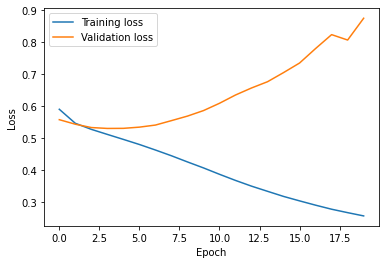

In [173]:
plt.plot(lstm_t_losses, label = "Training loss")
plt.plot(lstm_v_losses, label = "Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

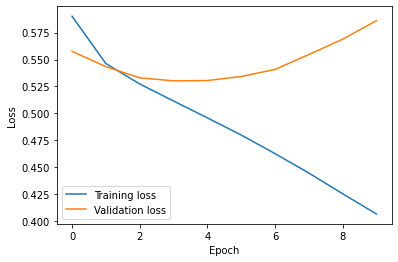

In [174]:
plt.plot(lstm_t_losses[:10], label = "Training loss")
plt.plot(lstm_v_losses[:10], label = "Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()